In [50]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
shuffle_setting = True
fn = 'trv2_data8_0.5_1000.csv'
file_location = 'code2\\'+fn
bres=64
def load_data():
  dataset = pd.read_csv(file_location)
  dataset = dataset.iloc[1:800, :]
  images = []
  nrow=0
  for img in dataset.pixels:
    nrow += 1
    if (nrow%100 == 0 ): 
        print("... row # {}".format(nrow))
    reshapedImage = np.fromstring(img, dtype=float, sep=' ').reshape(bres, bres)
    images.append(reshapedImage);
  emotions = pd.get_dummies(dataset.emotion).values.astype('float32')
  return images, emotions

np.random.seed(100)
images, emotions = load_data()

# Splitting data into train, test and validation
X_train, X_rem, y_train, y_rem = train_test_split(images, emotions, train_size=0.8,\
                                                  shuffle=shuffle_setting)

... row # 100
... row # 200
... row # 300
... row # 400
... row # 500
... row # 600


In [52]:
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, shuffle=False)
def type_cast(data):
    return np.array(data, 'float32')
X_train = type_cast(X_train)
X_test = type_cast(X_test)
X_valid = type_cast(X_valid)
X_train = X_train.reshape(X_train.shape[0], bres,bres,1)
X_test = X_test.reshape(X_test.shape[0],    bres, bres,1)
X_valid = X_valid.reshape(X_valid.shape[0], bres, bres,1)

In [53]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [54]:
epochs = 70
path = './'

In [55]:
preproc = ImageDataGenerator(rotation_range=20,width_shift_range=0.2,
            height_shift_range=0.2,horizontal_flip=True,
    featurewise_std_normalization=False,zoom_range=.2)

# Model structure

In [56]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding='same' ,input_shape=(bres, bres,1), 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [57]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], \
              optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                      

In [58]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
log_file_path = path + 'painlevel.log'
clogger = CSVLogger(log_file_path, append=False)
estop = EarlyStopping(monitor='val_loss',patience=6, verbose=1,
                 restore_best_weights=True)
chkpt = ModelCheckpoint(path + 'painlevel.ckpt',
                             save_weights_only=True,
                             verbose=1)
callbacks = [clogger, estop, chkpt]

# Model training

In [59]:
m = model.fit(preproc.flow(X_train, y_train, 64), 
                    validation_data = (X_valid, y_valid),
                    shuffle = True,
                    verbose = 1,
                    epochs = epochs, 
                    steps_per_epoch = len(X_train)/64,
                    callbacks = callbacks)

Epoch 1/70
9/8 [==============================] - ETA: 0s - loss: 1.5165 - accuracy: 0.5789
Epoch 1: saving model to .\painlevel.ckpt
8/8 [==============================] - 10s 995ms/step - loss: 1.5165 - accuracy: 0.5789 - val_loss: 9.5799 - val_accuracy: 0.7143
Epoch 2/70
9/8 [==============================] - ETA: 0s - loss: 0.9729 - accuracy: 0.6738
Epoch 2: saving model to .\painlevel.ckpt
8/8 [==============================] - 7s 834ms/step - loss: 0.9729 - accuracy: 0.6738 - val_loss: 7.4352 - val_accuracy: 0.7143
Epoch 3/70
9/8 [==============================] - ETA: 0s - loss: 0.8298 - accuracy: 0.7294
Epoch 3: saving model to .\painlevel.ckpt
8/8 [==============================] - 7s 834ms/step - loss: 0.8298 - accuracy: 0.7294 - val_loss: 8.3115 - val_accuracy: 0.7143
Epoch 4/70
9/8 [==============================] - ETA: 0s - loss: 0.7348 - accuracy: 0.7258
Epoch 4: saving model to .\painlevel.ckpt
8/8 [==============================] - 9s 1s/step - loss: 0.7348 - accuracy:

In [60]:
model.evaluate(X_test, y_test)
model.save('./painlevel_'+str(bres)+"_"+fn+'.hdf5')

3/3 [==============================] - 0s 59ms/step - loss: 2.0871 - accuracy: 0.7571


# Visualization

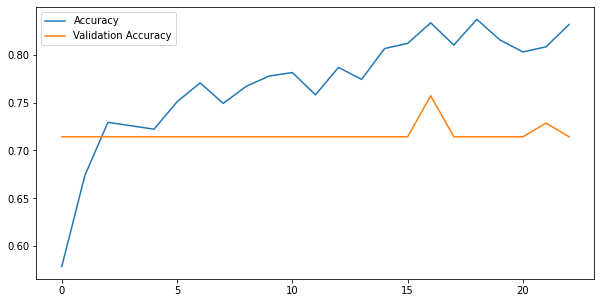

In [61]:
# Read the log file from the drive
log = pd.read_csv('./painlevel.log')

# Plotting the figure of accuracy and validation accuracy over epoch
plt.figure(figsize=(10,5))
# Plot the data from the model
plt.plot(m.history['accuracy'], label='Accuracy')
plt.plot(m.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

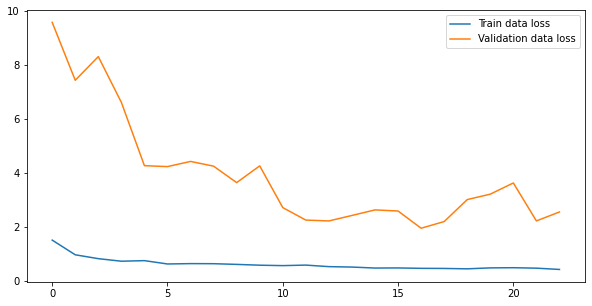

In [62]:
plt.figure(figsize=(10,5))
plt.plot(m.history['loss'], label='Train data loss')
plt.plot(m.history['val_loss'], label='Validation data loss')
plt.legend()

3/3 [==============================] - 0s 52ms/step


<AxesSubplot:>

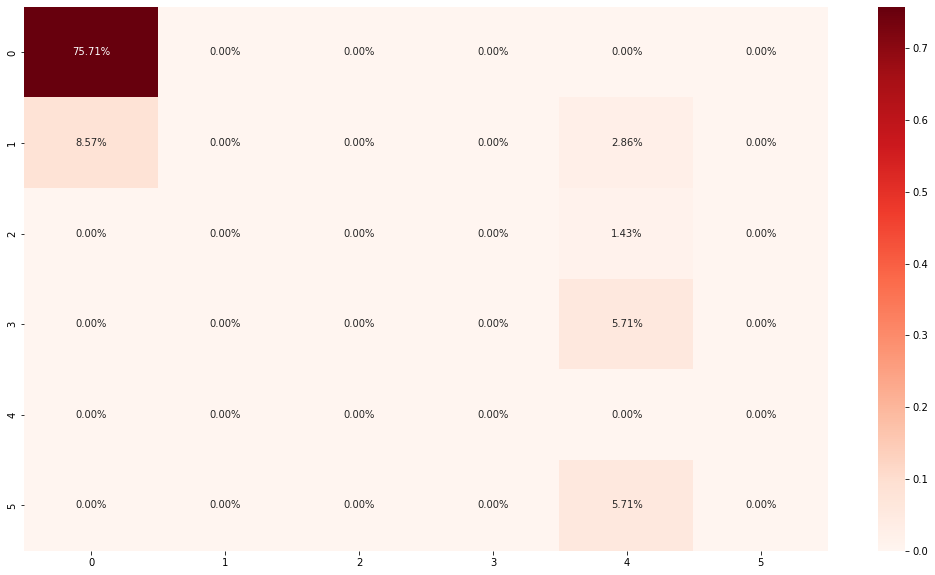

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
test_data_prediction = model.predict(X_test).argmax(axis=1)
label_x_test = np.array(y_test)
label_x_test = np.where(label_x_test)[1]
confusion_matrix_values = confusion_matrix(label_x_test, test_data_prediction)
plt.figure(figsize = (18,10))
sns.heatmap(confusion_matrix_values/np.sum(confusion_matrix_values), 
            annot=True, fmt='0.2%', cmap='Reds')

<AxesSubplot:xlabel='emotion', ylabel='count'>

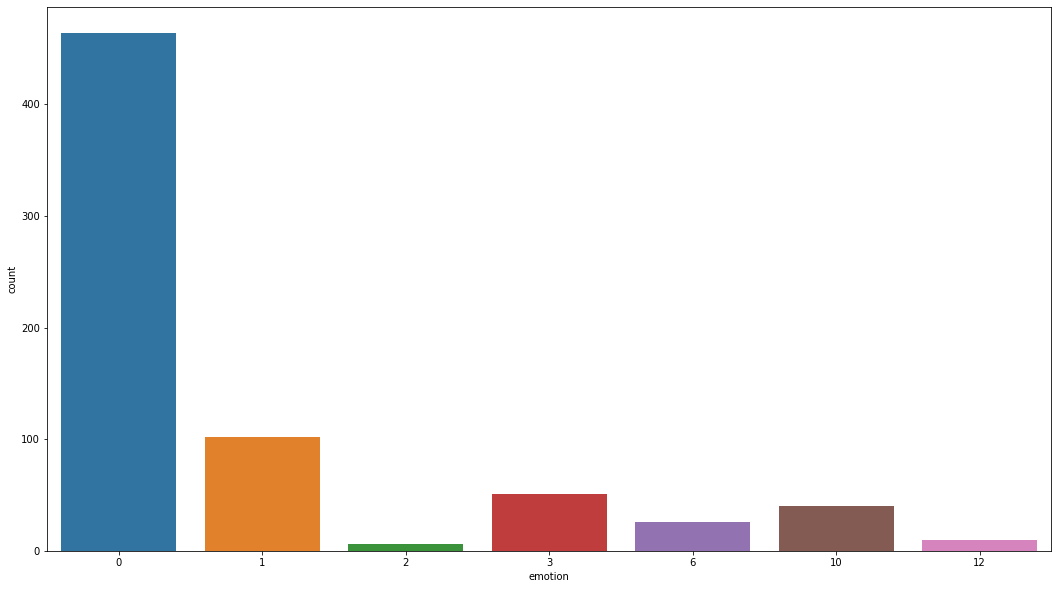

In [64]:
plt.figure(figsize = (18,10))
dataset = pd.read_csv(file_location)
sns.countplot(x='emotion', data = dataset)

# Prediction

In [65]:
from PIL import Image
import tensorflow as tf 
import cv2
expressions = range(15)
mfile='painlevel_'+str(bres)+"_"+fn+'.hdf5'
model = tf.keras.models.load_model(mfile)
def predict(val, flg=0, v=-1, mver="ttnn"):
  img = X_test[val].reshape(1,bres,bres,1)
  if flg & 8:
        print(X_test[val])
  if flg& 1:
        plt.imshow(X_test[val].reshape(bres, bres) ,cmap='gray')
        plt.show()
  act = expressions[np.argmax(y_test[val])]
  if flg & 2:
        print("Actual : ", act)
  if v > -1:
       tmpmodel = tf.keras.models.load_model('emotion_'+str(bres)+'v'+str(ver)+"_mver_"+mver+'.hdf5')
  else:
       tmpmodel = model   
  pred = expressions[np.argmax(tmpmodel.predict(img)[0])]
  if flg & 2:
        print("Predicted: ", pred)
  return act, pred

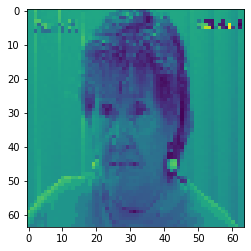

1/1 [==============================] - 0s 196ms/step
file .//code2//subflat//VW121T1AAAFF071.png prediction is 4


4

In [66]:
def predictimg(fname, flg=27, v=-1, mver="ttnn"): 
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    img4 = cv2.resize(img, (bres,bres))
    img5=img4.reshape(1,bres, bres,1)
    if flg & 8:
        print('type:', type(img5[0][0][0]), ' len:', len(img5[0][0][0]))
        for i in range(bres):
            s1 = ' '.join([str(*img5[0][i][j]) for j in range(bres)])
            print(s1)
    if v > -1:
        tmpmodel = tf.keras.models.load_model('emotion_'+str(bres)+'v'+str(ver)+"_mver_"+mver+'.hdf5')
    else:
        tmpmodel = model      
    if flg & 2:
        plt.imshow(img5.reshape(bres, bres) )#,cmap='gray')
        plt.show()
    if flg & 16:
        img6 = type_cast(img4)
        img7 = img6.reshape(1,bres, bres, 1)
    else:
        img7 = img5
    prediction = expressions[np.argmax(tmpmodel.predict(img7)[0])]
    if flg & 1:
        print('file {0} prediction is {1}'.format(fname, prediction))
    return prediction

predictimg(".//code2//subflat//VW121T1AAAFF071.png", 19)

In [67]:
match=0
net=50
for i in range(0,net ):
    act, pred = predict(i)
    #if (act != 0):
    #    print(act)
    if (act == pred):
          match+=1
    else:
          print(f'{i} {act} {pred}')
print(f"accuracy test: {match*100/net}")

1/1 [==============================] - 0s 32ms/step
5 1 0
1/1 [==============================] - 0s 36ms/step
10 2 4
1/1 [==============================] - 0s 33ms/step
11 3 4
1/1 [==============================] - 0s 35ms/step
12 1 0
1/1 [==============================] - 0s 30ms/step
27 1 0
1/1 [==============================] - 0s 32ms/step
28 5 4
1/1 [==============================] - 0s 33ms/step
33 1 0
1/1 [==============================] - 0s 33ms/step
40 5 4
1/1 [==============================] - 0s 32ms/step
41 1 4
1/1 [==============================] - 0s 31ms/step
43 1 4
1/1 [==============================] - 0s 36ms/step
46 5 4
1/1 [==============================] - 0s 33ms/step
accuracy test: 78.0
